In [1]:
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO

In [2]:
class_names={
    0:'battery',
    1:'chew-gum',
    2:'chocolate',
    3:'cigaretes',
    4:'crema',
    5:'lighter',
    6:'pen',
    7:'screwdriver',
    8:'usb'
}

# Create functions

In [3]:
def detect_aruco_markers(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    arucoDict = dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
    arucoParams = aruco.DetectorParameters()
    detector = aruco.ArucoDetector(dictionary, arucoParams)
    markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(img)
    #aruco.drawDetectedMarkers(img,markerCorners)
    return markerIds,np.squeeze(markerCorners)

In [4]:
markerDetails={}
def get_aruco_informations(img):
    markerIds, markerCorners = detect_aruco_markers(img)
    for i,ida in enumerate(markerIds):
        rect = cv2.minAreaRect(markerCorners[i].reshape((-1, 1, 2)))
        # Extract the center and other information from the rectangle
        center, size, angle = rect
        markerDetails[ida[0]]=np.array([np.round(center),np.round(size)],dtype=np.int16)

In [5]:
def read_predictions():
    file_name="../ehqnpwtj.txt"
    #predictions=np.array([])
    file = open(file_name).readlines()
    for line in file:
            name_class,x1,y1,x2,y2,x3,y3,x4,y4=map(float,line.split())
            x1,y1,x2,y2,x3,y3,x4,y4=[np.round(x*640) for x in [x1,y1,x2,y2,x3,y3,x4,y4]]
            #cordinates=[np.round(np.array([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])*640)]
            yield np.array([name_class,x1,y1,x2,y2,x3,y3,x4,y4])

    #predictions=predictions.reshape(-1,9).astype(np.float32)
    #predictions

In [6]:
class Positionss():
    def __init__(self,model_path):
        self.model_path = model_path
        self.line1_lenght=315
        self.line2_lenght=330
        self.y_zero=140
        self.x_zero=54
        self.line1=0
        self.line2=0
        self.model=YOLO(model_path)
        self.markerDetails = {}
        self.predDetails = np.array([])
        self.markerCorners=np.array([])
        self.markerIds=np.array([])
    
        
    def __detect_aruco_markers(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        arucoDict = dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
        arucoParams = aruco.DetectorParameters()
        detector = aruco.ArucoDetector(dictionary, arucoParams)
        markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(img)
        #aruco.drawDetectedMarkers(img,markerCorners)
        self.markerCorners=np.squeeze(markerCorners)
        self.markerIds=markerIds
    
    def get_aruco_informations(self):
        self.__detect_aruco_markers()
        for i,ida in enumerate(self.markerIds):
            rect = cv2.minAreaRect(self.markerCorners[i].reshape((-1, 1, 2)))
            # Extract the center and other information from the rectangle
            center, size, angle = rect
            self.markerDetails[ida[0]]=np.array([np.round(center),np.round(size)],dtype=np.int16)
        b=self.markerDetails[1][0][1]-self.markerDetails[2][0][1]
        print("printam")
        print(b)
        self.line1=cv2.norm(self.markerDetails[0][0],self.markerDetails[1][0])
        self.line2=cv2.norm(self.markerDetails[1][0],self.markerDetails[2][0])
        fi=np.degrees(np.arcsin(b/self.line2))
        print(fi)
        print(self.line2)
    def __remove_aruco_markers(self,img):
        color=(255,255,255)
        for i,ids in enumerate(self.markerIds):
            #print(self.markerIds[i])
            aruco=self.markerCorners[i]
            x_u=np.min(aruco[:,0]).astype(np.int32)-5
            x_d=np.max(aruco[:,0]).astype(np.int32)+5
            y_u=np.min(aruco[:,1]).astype(np.int32)-5
            y_d=np.max(aruco[:,1]).astype(np.int32)+5
            color=img[y_u-2,x_u-2]
            img[y_u:y_d,
                x_u:x_d] = np.full(((y_d-y_u),(x_d-x_u),3), color)
            #if self.markerIds[i][0]==2:
            #    print(self.markerIds[i][0])
            #    print(aruco)
            #    print(img.shape)
            #    img[:,:x_u]=np.full((img.shape[0],(x_u),3), img[y_u-2,x_u-2])
            #    print(img[:,(x_d):].shape)
        pts=np.array([self.markerDetails[0][0],self.markerDetails[1][0],
                      self.markerDetails[2][0],[self.markerDetails[2][0][0],self.markerDetails[0][0][1]],
                      [0,0],[0,640],[640,640],[640,0],
                      [0,0],[self.markerDetails[2][0][0],self.markerDetails[0][0][1]]]) 
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(img, [pts], tuple(int(x) for x in color))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    def predict(self,img):
        self.get_aruco_informations(img)
        results=self.model.predict(self.__remove_aruco_markers(img),conf=0.55,)[0].obb
        #plt.imshow(img)
        for i, result in enumerate(results.cls):
            yield np.append(np.array([result.numpy(),results.conf[i]]),np.array([results.xyxyxyxy[i].numpy().reshape(1,-1)[0]]))
            #self.predictions=np.append(self.predictions,np.append(np.array([result.numpy(),results.conf[i]]),np.array([results.xyxyxyxy[i].numpy().reshape(1,-1)[0]])))
        #self.predictions = self.predictions.reshape(-1,5,2)
        print(len(results.cls))
    def calculate_angle(self,pred,img,pred_angle):
        x_preds=np.array([pred[2],pred[4],pred[6],pred[8]])
        y_preds=np.array([pred[3],pred[5],pred[7],pred[9]])
        # X_1, y_1
        x_pos=np.where(x_preds==np.max(x_preds))
        X_1=x_preds[x_pos][0]
        y_1=y_preds[x_pos][0]
        y_pos=np.where(y_preds==np.max(y_preds))
        X_2=x_preds[y_pos][0]
        y_2=y_preds[y_pos][0]
        
        # X_2, y_2
        x_pos2=np.where(x_preds==np.min(x_preds))
        X_1_=x_preds[x_pos2][0]
        y_1_=y_preds[x_pos2][0]
        y_pos2=np.where(y_preds==np.max(y_preds))
        X_2_=x_preds[y_pos2][0]
        y_2_=y_preds[y_pos2][0]
        
        # Calculate distances
        line1=cv2.norm(np.round([X_1,y_1]).astype(np.int32),np.round([X_2,y_2]).astype(np.int32))
        line2=cv2.norm(np.round([X_1_,y_1_]).astype(np.int32),np.round([X_2_,y_2_]).astype(np.int32))

        if(line1>line2):
            return 90-pred_angle
        else:
            return -pred_angle
        
    def get_positions(self,img):
        for pred in self.predict(img):
            center, size, pred_angle = cv2.minAreaRect(pred[2:].reshape(-1,1,2))
            angle=self.calculate_angle(pred,img,pred_angle)
            self.predDetails=np.append(self.predDetails,[[pred[0],angle],np.round(center),np.round(size)])
        self.predDetails=self.predDetails.reshape(-1,3,2)
    
    def __get_center(self,class_num):
        return self.predDetails[self.predDetails[:,0,0]==class_num][0,1]
    def __get_angle(self,class_num):
        return self.predDetails[self.predDetails[:,0,0]==class_num][0,0,1]    
    
    def get_cordinates(self,class_num,center):
        #center = self.__get_center(class_num)
        
        x=(center[1]-self.markerDetails[0][0,1])*(self.line1_lenght/self.line1)-self.x_zero
        y=(self.markerDetails[1][0,0]-center[0])*(self.line2_lenght/self.line2)-self.y_zero
        if y<=0:
            y+=y/10
        else:
            y+=y/4.5
        
        x+=x/14
        return np.round(x),np.round(-y)#,np.round(self.__get_angle(class_num))

In [3]:
class ArucoDetector:
    def __init__(self):
        self.markerCorners=np.array([])
        self.markerIds=np.array([])
        self.markerDetails = {}
        self.cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH,800) 
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT,600) 
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        self.line1=0
        self.line2=0
        self.img = 0#np.zeros(shape=(640,640,3))
    def get_image(self):
        if self.cap.isOpened():
            succes, img = self.cap.read()
            if((img==self.img).all()):
                self.get_image()
            self.img =cv2.cvtColor( cv2.resize(img,(640,640)), cv2.COLOR_BGR2RGB)
        
    def remove_aruco_markers(self):
        color=(255,255,255)
        clear_img=self.img
        for i,ids in enumerate(self.markerIds):
            #print(self.markerIds[i])
            aruco=self.markerCorners[i]
            x_u=np.min(aruco[:,0]).astype(np.int32)-5
            x_d=np.max(aruco[:,0]).astype(np.int32)+5
            y_u=np.min(aruco[:,1]).astype(np.int32)-5
            y_d=np.max(aruco[:,1]).astype(np.int32)+5
            color=clear_img[y_u-2,x_u-2]
            clear_img[y_u:y_d,
                x_u:x_d] = np.full(((y_d-y_u),(x_d-x_u),3), color)
        pts=np.array([self.markerDetails[0][0],self.markerDetails[1][0],
                      self.markerDetails[2][0],[self.markerDetails[2][0][0],self.markerDetails[0][0][1]],
                      [0,0],[0,640],[640,640],[640,0],
                      [0,0],[self.markerDetails[2][0][0],self.markerDetails[0][0][1]]]) 
        pts = pts.reshape((-1,1,2))
        cv2.fillPoly(clear_img, [pts], tuple(int(x) for x in color))
        return cv2.cvtColor(clear_img, cv2.COLOR_BGR2RGB)
    
    def __detect_aruco_markers(self):
        self.get_image()
        gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        arucoDict = dictionary = aruco.getPredefinedDictionary(aruco.DICT_4X4_50)
        arucoParams = aruco.DetectorParameters()
        detector = aruco.ArucoDetector(dictionary, arucoParams)
        markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(self.img)
        print(len(markerCorners))
        if(len(markerCorners)!=3):
            self.__detect_aruco_markers()
        #aruco.drawDetectedMarkers(img,markerCorners)
        self.markerCorners=np.squeeze(markerCorners)
        self.markerIds=markerIds

    
    def get_aruco_informations(self):
        self.__detect_aruco_markers()
        for i,ida in enumerate(self.markerIds):
            rect = cv2.minAreaRect(self.markerCorners[i].reshape((-1, 1, 2)))
            # Extract the center and other information from the rectangle
            center, size, angle = rect
            self.markerDetails[ida[0]]=np.array([np.round(center),np.round(size)],dtype=np.int16)
        self.line1=cv2.norm(self.markerDetails[0][0],self.markerDetails[1][0])
        self.line2=cv2.norm(self.markerDetails[1][0],self.markerDetails[2][0])

In [4]:
class YOLOPredictor():
    def __init__(self,model_path):
        self.model_path = model_path
        self.model=YOLO(model_path)
    
    def predict(self,img):
        results=self.model.predict(img,conf=0.55,)[0].obb
        #plt.imshow(img)
        for i, result in enumerate(results.cls):
            yield np.append(np.array([result.numpy(),results.conf[i]]),np.array([results.xyxyxyxy[i].numpy().reshape(1,-1)[0]]))
            #self.predictions=np.append(self.predictions,np.append(np.array([result.numpy(),results.conf[i]]),np.array([results.xyxyxyxy[i].numpy().reshape(1,-1)[0]])))
        #self.predictions = self.predictions.reshape(-1,5,2)
        print(len(results.cls))

In [5]:
class PositionCalculator:
    def __init__(self,arucoDetector,YOLOPredictor):
        self.line1_lenght=315
        self.line2_lenght=330
        self.y_zero=140
        self.x_zero=54
        self.predDetails = np.array([])
        self.arucoDetector=arucoDetector
        self.YOLOPredictor=YOLOPredictor

    def __get_center(self,class_num):
        return self.predDetails[self.predDetails[:,0,0]==class_num][0,1]
    def __get_angle(self,class_num):
        return self.predDetails[self.predDetails[:,0,0]==class_num][0,0,1]    
    
    def __get_z(self,c):
        if(c<130):
            return 8
        if c<=160:
            return 8+(2/30)*(c-130)
        if c<=190:
            return 10+(4/30)*(c-160)
        if c<=220:
            return 14+(6/30)*(c-190)
        if c<=250:
            return 20+(5/30)*(c-220)
        if c>=250:
            return 25+(7/20)*(c-250)
        
    def get_cordinates(self,class_num):
        center = self.__get_center(class_num)
        x=(center[1]-self.arucoDetector.markerDetails[0][0,1])*(self.line1_lenght/self.arucoDetector.line1)-self.x_zero
        y=(self.arucoDetector.markerDetails[1][0,0]-center[0])*(self.line2_lenght/self.arucoDetector.line2)-self.y_zero
        if y<=0:
            y+=y/10
        else:
            y+=y/4.5
        
        x+=x/14
        return np.round(x),np.round(-y),np.round(self.__get_z(np.sqrt(x**2+y**2))),np.round(self.__get_angle(class_num))
    def calculate_angle(self,pred,pred_angle):
        x_preds=np.array([pred[2],pred[4],pred[6],pred[8]])
        y_preds=np.array([pred[3],pred[5],pred[7],pred[9]])
        # X_1, y_1
        x_pos=np.where(x_preds==np.max(x_preds))
        X_1=x_preds[x_pos][0]
        y_1=y_preds[x_pos][0]
        y_pos=np.where(y_preds==np.max(y_preds))
        X_2=x_preds[y_pos][0]
        y_2=y_preds[y_pos][0]
        
        # X_2, y_2
        x_pos2=np.where(x_preds==np.min(x_preds))
        X_1_=x_preds[x_pos2][0]
        y_1_=y_preds[x_pos2][0]
        y_pos2=np.where(y_preds==np.max(y_preds))
        X_2_=x_preds[y_pos2][0]
        y_2_=y_preds[y_pos2][0]
        
        # Calculate distances
        line1=cv2.norm(np.round([X_1,y_1]).astype(np.int32),np.round([X_2,y_2]).astype(np.int32))
        line2=cv2.norm(np.round([X_1_,y_1_]).astype(np.int32),np.round([X_2_,y_2_]).astype(np.int32))

        if(line1>line2):
            return 90-pred_angle
        else:
            return -pred_angle
    def get_positions(self,img):
        for pred in self.YOLOPredictor.predict(img):
            center, size, pred_angle = cv2.minAreaRect(pred[2:].reshape(-1,1,2))
            angle=self.calculate_angle(pred,pred_angle)
            self.predDetails=np.append(self.predDetails,[[pred[0],angle],np.round(center),np.round(size)])
        self.predDetails=self.predDetails.reshape(-1,3,2)

In [6]:
class Positions:
    def __init__(self,model_path):
        self.arucoDetector = ArucoDetector()
        self.YOLOPredictor =YOLOPredictor(model_path=model_path)
        self.positionCalculator =PositionCalculator(arucoDetector=self.arucoDetector,YOLOPredictor=self.YOLOPredictor)
    def find_positions(self):
        self.arucoDetector.get_aruco_informations()
        self.positionCalculator.get_positions(img=self.arucoDetector.remove_aruco_markers())
    def get_cordinates(self,class_num):
        return self.positionCalculator.get_cordinates(class_num)

# Test_funcs

In [7]:
# Get image
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
cap.set(cv2.CAP_PROP_FRAME_WIDTH,800) 
cap.set(cv2.CAP_PROP_FRAME_HEIGHT,600) 
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
dim =(640,640)

In [8]:
if cap.isOpened():
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    succes, img = cap.read()
    img =cv2.cvtColor( cv2.resize(img,dim), cv2.COLOR_BGR2RGB)
    print("done")

done


In [9]:
# Load image
#img = cv2.imread("img3.png")
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

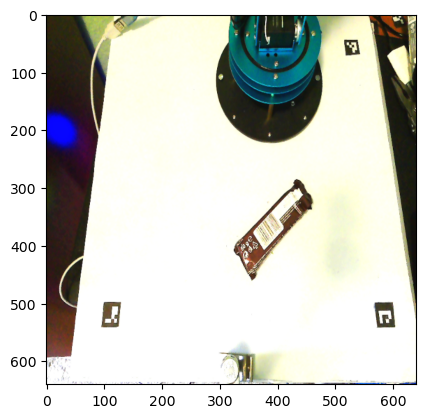

In [10]:
plt.imshow(img)

In [11]:
#cv2.imwrite("img3.png",cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [12]:
positions = Positions(model_path="../obb-best.pt")

In [13]:
positions.find_positions()

3

0: 640x640 908.9ms
Speed: 4.0ms preprocess, 908.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)
1


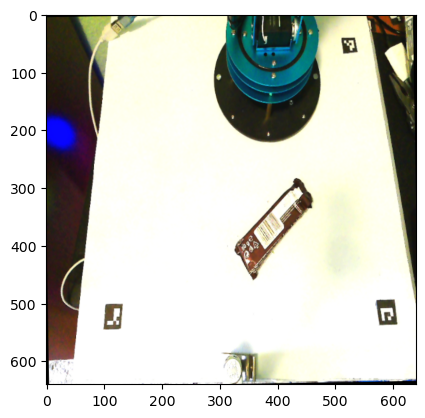

In [14]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
imgs=rotate_image(img,0.9710219310791666)
plt.imshow(imgs)

In [15]:
positions.get_cordinates(0,(251,387))

TypeError: get_cordinates() takes 2 positional arguments but 3 were given

In [ ]:
positions.find_positions(img)

In [63]:
positions.get_cordinates(2)

(209.0, 28.0, 18.0, 69.0)

In [ ]:
positions.markerDetails

In [ ]:
detect_aruco_markers(img)